In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


ModuleNotFoundError: No module named 'pandas'

In [2]:
data = pd.read_csv('A15/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
# note the seprator in this file
data_text =pd.read_csv("A15/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 169.431687 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.18)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.22)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2123
Number of data points in test data: 598
Number of data points in cross validation data: 600


In [12]:
X_train.head()

,ID,Gene,Variation,Class,TEXT
2962,2962,KIT,L576del,7,many studies highlighted critical role c kit n...
2632,2632,BRCA1,I42V,3,published analyses effects missense mutations ...
2687,2687,BRAF,L485_P490del,7,identifi ed previously undiscovered braf frame...
2834,2834,BRCA2,K2950N,5,mutation screening breast ovarian cancer predi...
1200,1200,PIK3CA,H1047L,7,introduction 2004 samuels et al reported resul...


In [13]:
i=0
list_of_sentance=[]
for sentance in train_df['Gene']:
    list_of_sentance.append(sentance.split())

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
w2v_model=Word2Vec(list_of_sentance,min_count=1,size=100, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [15]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_tr.append(sent_vec)
print(len(vectors_tr))
print(len(vectors_tr[0]))

100%|██████████| 2123/2123 [00:00<00:00, 68185.70it/s]

2123
100


In [16]:
list_of_sentance=[]
for sentance in test_df['Gene']:
    list_of_sentance.append(sentance.split())
vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_test.append(sent_vec)
print(len(vectors_test))
print(len(vectors_test[0]))

100%|██████████| 598/598 [00:00<00:00, 22799.90it/s]

598
100


In [17]:
list_of_sentance=[]
for sentance in cv_df['Gene']:
    list_of_sentance.append(sentance.split())
vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_cv.append(sent_vec)
print(len(vectors_cv))
print(len(vectors_cv[0]))

100%|██████████| 600/600 [00:00<00:00, 14077.37it/s]

600
100


In [18]:
i=0
list_of_sentance=[]
for sentance in train_df['Variation']:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=1,size=100, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [19]:
vectors_tr_var = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_tr_var.append(sent_vec)
print(len(vectors_tr_var))
print(len(vectors_tr_var[0]))

100%|██████████| 2123/2123 [00:00<00:00, 21266.63it/s]

2123
100


In [20]:
list_of_sentance=[]
for sentance in cv_df['Variation']:
    list_of_sentance.append(sentance.split())
vectors_cv_var = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_cv_var.append(sent_vec)
print(len(vectors_cv_var))
print(len(vectors_cv_var[0]))

100%|██████████| 600/600 [00:00<00:00, 23643.65it/s]

600
100


In [21]:
list_of_sentance=[]
for sentance in test_df['Variation']:
    list_of_sentance.append(sentance.split())
vectors_test_var = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_test_var.append(sent_vec)
print(len(vectors_test_var))
print(len(vectors_test_var[0]))

100%|██████████| 598/598 [00:00<00:00, 23879.83it/s]

598
100


In [22]:
i=0
list_of_sentance=[]
for sentance in train_df['TEXT']:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=1,size=100, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [23]:
vectors_tr_text = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_tr_text.append(sent_vec)
print(len(vectors_tr_text))
print(len(vectors_tr_text[0]))

100%|██████████| 2123/2123 [44:15<00:00,  1.25s/it]

2123
100


In [24]:
list_of_sentance=[]
for sentance in cv_df['TEXT']:
    list_of_sentance.append(sentance.split())
vectors_cv_text = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_cv_text.append(sent_vec)
print(len(vectors_cv_text))
print(len(vectors_cv_text[0]))

100%|██████████| 600/600 [14:12<00:00,  1.42s/it]

600
100


In [25]:
list_of_sentance=[]
for sentance in test_df['TEXT']:
    list_of_sentance.append(sentance.split())
vectors_test_text = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 50 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_test_text.append(sent_vec)
print(len(vectors_test_text))
print(len(vectors_test_text[0]))

100%|██████████| 598/598 [13:52<00:00,  1.39s/it]

598
100


In [30]:
train_df['word_count'] = train_df['TEXT'].apply(lambda x: len(str(x).split(" ")))
train_df[['TEXT','word_count']].head()
train_df['char_count'] = train_df['TEXT'].str.len() ## this also includes spaces
train_df[['TEXT','char_count']].head()
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train_df['avg_word'] = train_df['TEXT'].apply(lambda x: avg_word(x))
train_df[['TEXT','avg_word']].head()
train_df['numerics'] = train_df['TEXT'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train_df[['TEXT','numerics']].head()
test_df['word_count'] = test_df['TEXT'].apply(lambda x: len(str(x).split(" ")))
test_df['char_count'] = test_df['TEXT'].str.len()
test_df['avg_word'] = test_df['TEXT'].apply(lambda x: avg_word(x))
test_df['numerics'] = test_df['TEXT'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
cv_df['word_count'] = cv_df['TEXT'].apply(lambda x: len(str(x).split(" ")))
cv_df['char_count'] = cv_df['TEXT'].str.len()
cv_df['avg_word'] = cv_df['TEXT'].apply(lambda x: avg_word(x))
cv_df['numerics'] = cv_df['TEXT'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [53]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]
from scipy import sparse

train1 = hstack((sparse.csc_matrix(vectors_tr), sparse.csc_matrix(vectors_tr_text)))
test1 = hstack((sparse.csc_matrix(vectors_test), sparse.csc_matrix(vectors_test_text)))
cv1 = hstack((sparse.csc_matrix(vectors_cv), sparse.csc_matrix(vectors_cv_text)))

#train2 = hstack((train1, train_variation_feature_responseCoding))
#test2 = hstack((test1, test_variation_feature_responseCoding))
#cv2 = hstack((cv1, cv_variation_feature_responseCoding))

#train_x_responseCoding = hstack((train2, train_text_feature_responseCoding))
#test_x_responseCoding = hstack((test2, test_text_feature_responseCoding))
#cv_x_responseCoding = hstack((cv2, cv_text_feature_responseCoding))

train_x_onehotCoding = hstack((train1, sparse.csc_matrix(vectors_tr_var))).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test1, sparse.csc_matrix(vectors_test_var))).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv1, sparse.csc_matrix(vectors_cv_var))).tocsr()
cv_y = np.array(list(cv_df['Class']))



In [54]:
train_x_onehotCoding.shape

(2123, 300)

In [55]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [56]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [57]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer =TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53229


In [72]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [73]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [74]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [75]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [76]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [58]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [78]:

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [79]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [80]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [81]:
##from sklearn.decomposition import LatentDirichletAllocation

##lda = LatentDirichletAllocation(n_topics=9, max_iter=10, random_state=0,verbose=1)
#dt_matrix = lda.fit_transform(train_text_feature_onehotCoding)
#features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
#features

In [82]:
##dtest_matrix = lda.transform(test_text_feature_onehotCoding)

In [83]:
#dcv_matrix = lda.transform(cv_text_feature_onehotCoding)

In [63]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

#train1 = hstack((train_gene_var_onehotCoding, train_gene_feature_responseCoding))
#test1 = hstack((test_gene_var_onehotCoding, test_gene_feature_responseCoding))
#cv1 = hstack((cv_gene_var_onehotCoding, cv_gene_feature_responseCoding))

#train2 = hstack((train1, train_variation_feature_responseCoding))
#test2 = hstack((test1, test_variation_feature_responseCoding))
#cv2 = hstack((cv1, cv_variation_feature_responseCoding))

#train_x_responseCoding = hstack((train2, train_text_feature_responseCoding))
#test_x_responseCoding = hstack((test2, test_text_feature_responseCoding))
#cv_x_responseCoding = hstack((cv2, cv_text_feature_responseCoding))

train_x_onehotCoding1 = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding1 = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding1 = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))



In [64]:
train_x_onehotCoding1.shape

(2123, 55428)

In [62]:
normalize(train_df[['word_count','avg_word','numerics','char_count']]).shape

(2123, 4)

In [66]:
train_x_onehotCoding1 = hstack((normalize(train_df[['word_count','avg_word','numerics','char_count']]), train_x_onehotCoding1)).tocsr()
test_x_onehotCoding1= hstack((normalize(test_df[['word_count','avg_word','numerics','char_count']]),  test_x_onehotCoding1)).tocsr()
cv_x_onehotCoding1 = hstack((normalize(cv_df[['word_count','avg_word','numerics','char_count']]), cv_x_onehotCoding1)).tocsr()



In [67]:
train_x_onehotCoding.shape

(2123, 300)

In [68]:
train_x_onehotCoding = hstack((train_x_onehotCoding, train_x_onehotCoding1)).tocsr()

test_x_onehotCoding = hstack((test_x_onehotCoding, test_x_onehotCoding1)).tocsr()

cv_x_onehotCoding = hstack((cv_x_onehotCoding, cv_x_onehotCoding1)).tocsr()


In [69]:
train_x_onehotCoding.shape

(2123, 55732)

In [70]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2123, 55732)
(number of data points * number of features) in test data =  (598, 55732)
(number of data points * number of features) in cross validation data = (600, 55732)


for alpha = 1e-06
Log Loss : 1.1412402390916976
for alpha = 1e-05
Log Loss : 1.1436125312473777
for alpha = 0.0001
Log Loss : 1.1396687851801306
for alpha = 0.001
Log Loss : 1.0698701516867313
for alpha = 0.01
Log Loss : 1.0238363929787044
for alpha = 0.1
Log Loss : 1.1521532919230983
for alpha = 1
Log Loss : 1.4312906808425685
for alpha = 10
Log Loss : 1.696578741378428
for alpha = 100
Log Loss : 1.7288870695776193


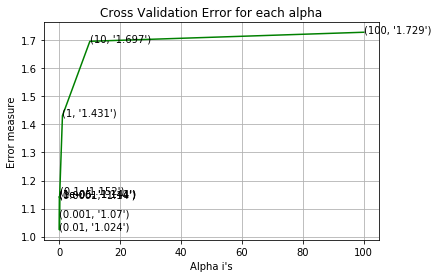

For values of best alpha =  0.01 The train log loss is: 0.7048285740260388
For values of best alpha =  0.01 The cross validation log loss is: 1.0265356936900063
For values of best alpha =  0.01 The test log loss is: 0.993769002940269


In [71]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=45)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [96]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=.005, penalty='l2', loss='log', random_state=45)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.5715343589976758
For values of best alpha =  0.01 The cross validation log loss is: 1.0243375124958258
For values of best alpha =  0.01 The test log loss is: 0.9494275442870569


In [99]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

4

In [35]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [36]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

Log loss : 1.0688175399947382
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


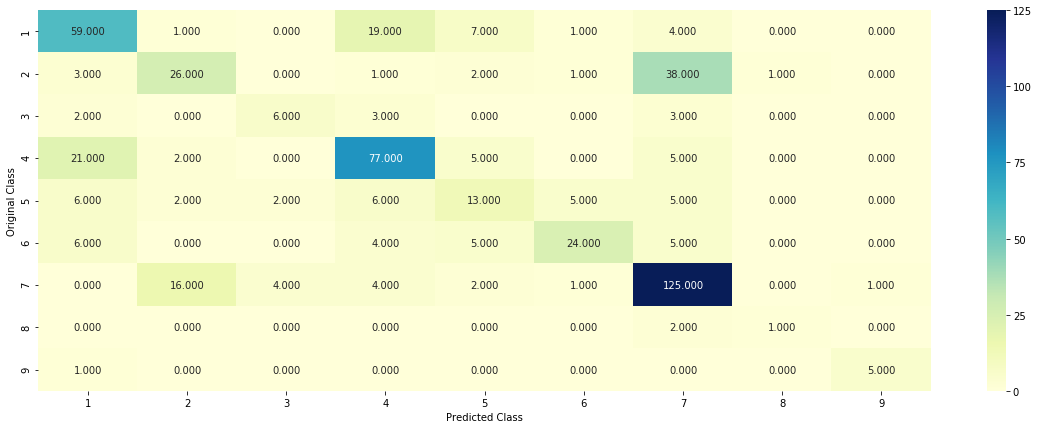

-------------------- Precision matrix (Columm Sum=1) --------------------


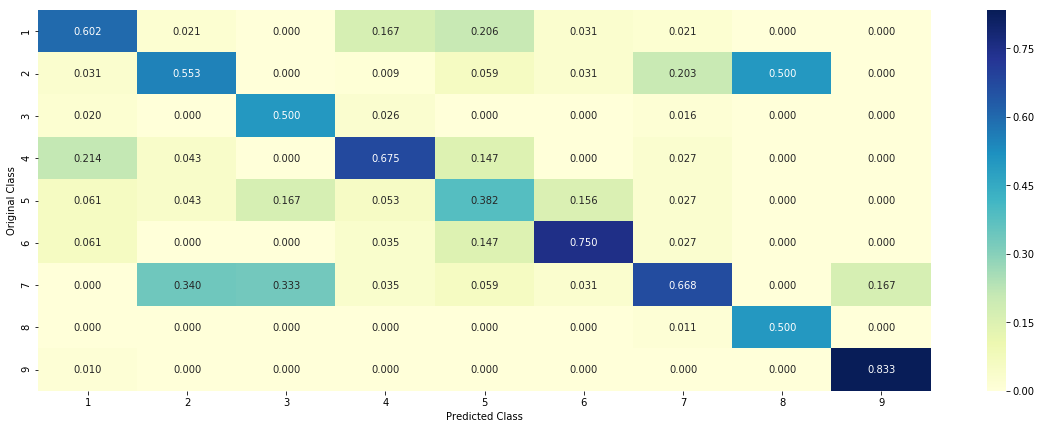

-------------------- Recall matrix (Row sum=1) --------------------


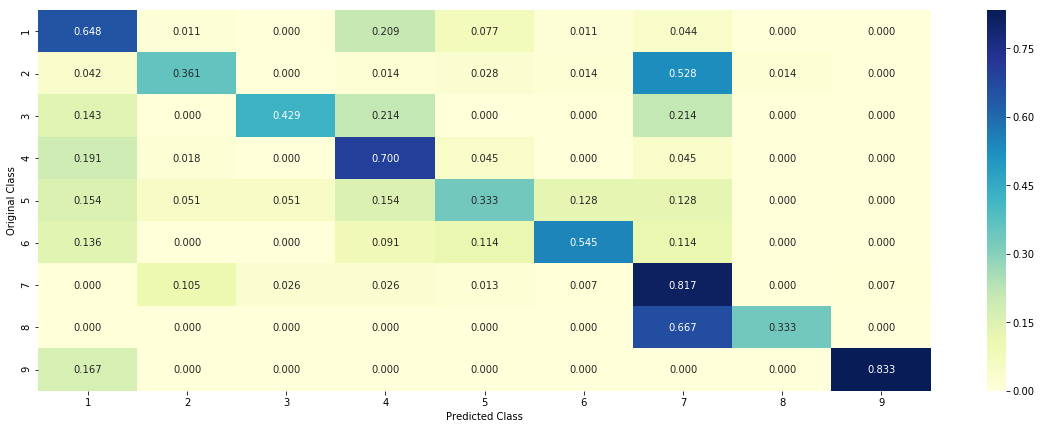

In [37]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)